Pascal VOC 2012 is the recommended dataset for this code and it can be downloaded from here:
http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

In [0]:
!pip install matplotlib scipy opencv-python-headless xmltodict selectivesearch pandas keras dill

    100% |████████████████████████████████| 18.8MB 2.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/ab/a0/bd/a56e017d10730401fce75f62ff9364004368b0b96f12c026ba
Successfully built selectivesearch


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
import json, scipy, os
import numpy as np, pandas as pd
import argparse, time, sys, gc, cv2

import xmltodict
from copy import deepcopy
import selectivesearch

In [0]:
xmls_root ="..."  # Path to the root folder of rtaining data to be provided here
annotations = xmls_root + "Annotations/"
jpegs = xmls_root + "JPEGImages/"
XMLs = os.listdir(annotations)
print(XMLs[:10]); print(len(XMLs))

In [0]:
def extract_iou2(candidate, current_y, img_shape):
  boxA = deepcopy(candidate)
  boxB = deepcopy(current_y)
  boxA[2] += boxA[0]
  boxA[3] += boxA[1]
  iou_img1 = np.zeros(img_shape)
  iou_img1[boxA[1]:boxA[3],boxA[0]:boxA[2]]=1

  iou_img2 = np.zeros(img_shape)
  iou_img2[int(boxB[1]):int(boxB[3]),int(boxB[0]):int(boxB[2])]=1
  iou = np.sum(iou_img1*iou_img2)/(np.sum(iou_img1)+np.sum(iou_img2)-np.sum(iou_img1*iou_img2))
  return iou

def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=100, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < (0.05*img_area):
            continue
        if r['size'] > (1*img_area):
            continue
        # distorted rects
        x, y, w, h = r['rect']
    #     if w / h > 1.2 or h / w > 1.2:
    #         continue
        candidates.append(list(r['rect']))
    return candidates

In [0]:
from keras.applications import vgg16
from keras.utils.vis_utils import plot_model
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step


In [0]:
ix = np.random.randint(len(XMLs))
sample_xml = XMLs[ix]
sample_xml = '{}/{}'.format(annotations, sample_xml)
with open(sample_xml, "rb") as f:    # notice the "rb" mode
    d = xmltodict.parse(f, xml_attribs=True)
d

OrderedDict([('annotation',
              OrderedDict([('filename', '2011_006833.jpg'),
                           ('folder', 'VOC2011'),
                           ('object',
                            [OrderedDict([('name', 'person'),
                                          ('actions',
                                           OrderedDict([('jumping', '0'),
                                                        ('other', '0'),
                                                        ('phoning', '0'),
                                                        ('playinginstrument',
                                                         '0'),
                                                        ('reading', '0'),
                                                        ('ridingbike', '0'),
                                                        ('ridinghorse', '0'),
                                                        ('running', '0'),
                                            

In [0]:
training_data_size = N = 1000

final_cls = []
final_delta = []
iou_list = []
imgs = []

for ix, xml in enumerate(XMLs[:N]):
    
    if(ix%50==0):
      print(ix)
            
    print('Extracted data from {} xmls...'.format(ix), end='\r')
    xml_file = annotations + xml
    fname = xml.split('.')[0]
    with open(xml_file, "rb") as f:    # notice the "rb" mode
        xml = xmltodict.parse(f, xml_attribs=True)
        l = []
        
        if isinstance(xml["annotation"]["object"], list):
            #'let us ignore cases with multiple objects...'
            continue

        #'extracting coordinates...'
        bndbox = xml['annotation']['object']['bndbox']
        for key in bndbox:
          bndbox[key] = float(bndbox[key])
        x1, x2, y1, y2 = [bndbox[key] for key in ['xmin', 'xmax', 'ymin', 'ymax']]

        img_size = xml['annotation']['size']
        for key in img_size:
          img_size[key] = float(img_size[key])
        w, h = img_size['width'], img_size['height']

        #'converting pixel values from bndbox to fractions...'
        x1 /= w; x2 /= w; y1 /= h; y2 /= h
        label = xml['annotation']['object']['name']

        y = [x1, y1, x2-x1, y2-y1, label] # i.e., top-left x & y, width and height

        filename = jpegs+fname+'.jpg' # Path to the image files to be provided here
        img = cv2.resize(cv2.imread(filename), (224,224)) # since VGG's input shape is 224x224
        candidates = extract_candidates(img)

        for jx, candidate in enumerate(candidates):

            current_y2 = [int(i*224) for i in [x1,y1,x2,y2]] # [int(x1*224), int(y1*224), int(x2*224), int(y2*224)]

            iou = extract_iou2(candidate, current_y2, (224, 224))

            candidate_region_coordinates = c_x1, c_y1, c_w, c_h = np.array(candidate)/224

            dx = c_x1 - x1 
            dy = c_y1 - y1 
            dw = c_w - (x2-x1)
            dh = c_h - (y2-y1)

            final_delta.append([dx,dy,dw,dh])         

            if(iou>0.3):                    
                final_cls.append(label)
            else:
                final_cls.append('background')

            #"We'll predict our candidate crop using VGG"
            l = int(c_x1 * 224)
            r = int((c_x1 + c_w) * 224)
            t = int(c_y1 * 224)
            b = int((c_y1 + c_h) * 224)

            img2 = img[t:b,l:r,:3]
            img3 = cv2.resize(img2,(224,224))/255
            img4 = vgg16_model.predict(img3.reshape(1,224,224,3))
            imgs.append(img4)
            # img4 = vgg16_model.predict(img3.reshape(1,224,224,3))
            # x_train.append(img4)
            iou_list.append(iou)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [0]:
targets = pd.DataFrame(final_cls, columns=['label'])
labels = pd.get_dummies(targets['label']).columns
y_train = pd.get_dummies(targets['label']).values.astype(float)

In [0]:
x_train = np.array(imgs)
x_train.shape

(21335, 1, 7, 7, 512)

In [0]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[2],x_train.shape[3],x_train.shape[4])

print(x_train.shape, y_train.shape, x_train.max())

(21335, 7, 7, 512) (21335, 21) 11.1770315


In [0]:
from keras.layers import Input, merge, Conv2D, MaxPooling2D,UpSampling2D, Dropout, Cropping2D, merge, concatenate
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.models import Model

model = Sequential()
model.add(Flatten(input_shape=((7,7,512))))
model.add(Dense(512, activation='relu'))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_2 (Dense)              (None, 21)                10773     
Total params: 12,856,341
Trainable params: 12,856,341
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train/x_train.max(), y_train, validation_split = 0.1, epochs=5, batch_size=32, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 19201 samples, validate on 2134 samples
Epoch 1/5
19201/19201 [==============================] - 14s 736us/step - loss: 0.0461 - acc: 0.9840 - val_loss: 0.0615 - val_acc: 0.9805
Epoch 2/5
19201/19201 [==============================] - 13s 658us/step - loss: 0.0175 - acc: 0.9941 - val_loss: 0.0677 - val_acc: 0.9782
Epoch 3/5
19201/19201 [==============================] - 13s 659us/step - loss: 0.0090 - acc: 0.9972 - val_loss: 0.1119 - val_acc: 0.9768
Epoch 4/5
19201/19201 [==============================] - 13s 657us/step - loss: 0.0059 - acc: 0.9982 - val_loss: 0.0952 - val_acc: 0.9781
Epoch 5/5
19201/19201 [==============================] - 13s 657us/step - loss: 0.0040 - acc: 0.9988 - val_loss: 0.0927 - val_acc: 0.9765


In [0]:
np.mean(y_train, axis=0)

array([0.01851418, 0.6809468 , 0.01040544, 0.01387392, 0.00365596,
       0.00220295, 0.00276541, 0.01654558, 0.02460745, 0.00628076,
       0.00449965, 0.00112491, 0.03923131, 0.00656199, 0.01209281,
       0.12481837, 0.00534333, 0.00426529, 0.00159363, 0.01303023,
       0.00764003])

In [0]:
'TESTING'
import matplotlib.patches as mpatches


ix = np.random.randint(N, len(XMLs))

filename = jpegs + XMLs[ix].replace('xml', 'jpg')

def test_predictions(filename):
    img = cv2.resize(cv2.imread(filename), (224,224))
    candidates = extract_candidates(img)

    _, ax = plt.subplots(1, 2)

    ax[0].imshow(img)
    ax[0].grid('off')
    ax[0].set_title(filename.split('/')[-1])


    pred = []
    pred_class = []

    for ix, candidate in enumerate(candidates):

        l, t, w, h = np.array(candidate).astype(int)

        img2 = img[t:t+h,l:l+w,:3]
        img3 = cv2.resize(img2,(224,224))/255
        img4 = vgg16_model.predict(img3.reshape(1,224,224,3))
        final_pred = model.predict(img4/x_train.max())
        pred.append(np.max(final_pred))
        pred_class.append(np.argmax(final_pred))

    pred = np.array(pred)
    pred_class = np.array(pred_class)

    pred2 = pred[pred_class!=1]
    pred_class2 = pred_class[pred_class!=1]

    candidates2 = np.array(candidates)[pred_class!=1]

    x, y, w, h = candidates2[np.argmax(pred2)]

    ax[1].set_title(labels[pred_class2[np.argmax(pred2)]])
    ax[1].imshow(img)
    ax[1].grid('off')
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax[1].add_patch(rect)



In [0]:
!wget https://www.dropbox.com/s/qdoximctirsy1a9/Hemanvi.jpg

--2019-02-25 17:01:01--  https://www.dropbox.com/s/qdoximctirsy1a9/Hemanvi.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qdoximctirsy1a9/Hemanvi.jpg [following]
--2019-02-25 17:01:02--  https://www.dropbox.com/s/raw/qdoximctirsy1a9/Hemanvi.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd06e38f3b3eb3d971decd8f366.dl.dropboxusercontent.com/cd/0/inline/AcA8r5wfAynhB74UMzxa5-i2cXDfH7t73-1LKmMZ3ObRnJZuelmFGD6WH_UuMfQs48RWb8SFMxVpC8Ob6kgN-wvUe0KW-B6Ka_hfKgpWN5XokwPHJg6sgt6CqoGvzOOLXv8/file# [following]
--2019-02-25 17:01:02--  https://ucd06e38f3b3eb3d971decd8f366.dl.dropboxusercontent.com/cd/0/inline/AcA8r5wfAynhB74UMzxa5-i2cXDfH7t73-1LKmMZ3ObRnJZuelmFGD6WH_UuMfQs48RWb8SFMxVpC8Ob6kgN-wvUe0KW-B6Ka_hfKgpWN5XokwPHJg

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


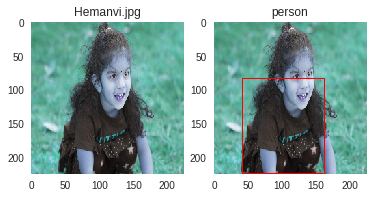

In [0]:
filename = '/content/Hemanvi.jpg'
test_predictions(filename)

In [0]:
model2 = Sequential()
model2.add(Flatten(input_shape=((7,7,512))))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(4,activation='linear'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2052      
Total params: 12,847,620
Trainable params: 12,847,620
Non-trainable params: 0
_________________________________________________________________


In [0]:
x_train.shape

(21335, 7, 7, 512)

In [0]:
np.max(np.array(final_delta), axis=0)

array([0.85960714, 0.86917857, 0.95953571, 0.91953571])

In [0]:
model2.compile(loss='mean_absolute_error',optimizer='adam')

In [0]:
pred = model.predict(x_train/x_train.max())
pred_class = np.argmax(pred, axis=1)

In [0]:
import random
samp=random.sample(range(len(x_train)),500)
x_train2=[x_train[i] for i in samp if pred_class[i]!=1]
np.array(x_train2).shape

(154, 7, 7, 512)

In [0]:
for i in range(1000):
  if(i%100==0):
    print(i)
  samp=random.sample(range(len(x_train)),500)
  x_train2=[x_train[i] for i in samp if pred_class[i]!=1]
  x_train2 = np.array(x_train2)
  final_delta2 = [final_delta[i] for i in samp if pred_class[i]!=1]
  model2.fit(x_train2/x_train.max(), np.array(final_delta2), validation_split = 0.1, epochs=1, batch_size=32, verbose=0)

0
100
200
300
400
500
600
700
800
900


In [0]:
'TESTING'
import matplotlib.patches as mpatches

def test_predictions2(filename):
    img = cv2.resize(cv2.imread(filename), (224,224))
    #print(img.shape)
    candidates = extract_candidates(img)

    _, ax = plt.subplots(1, 2)

    ax[0].imshow(img)
    ax[0].grid('off')
    ax[0].set_title(filename.split('/')[-1])


    pred = []
    pred_class = []
    del_new = []

    for ix, candidate in enumerate(candidates):

        l, t, w, h = np.array(candidate).astype(int)

        img2 = img[t:t+h,l:l+w,:3]
        img3 = cv2.resize(img2,(224,224))/255
        img4 = vgg16_model.predict(img3.reshape(1,224,224,3))        
        
        '''BATCH PROCESS THESE'''
        final_pred = model.predict(img4/x_train.max())
        delta_new = model2.predict(img4/x_train.max())[0]
        
        pred.append(np.max(final_pred))
        pred_class.append(np.argmax(final_pred))
        del_new.append(delta_new)
        
    pred = np.array(pred)
    pred_class = np.array(pred_class)

    non_bgs = (pred_class!=1)
    pred = pred[non_bgs]
    pred_class = pred_class[non_bgs]
    
    del_new = np.array(del_new)
    del_new = del_new[non_bgs]
    del_pred = del_new*224
    
    candidates = C = np.array(candidates)[non_bgs]
    C = np.clip(C, 0, 224)
    C[:,2] += C[:,0]
    C[:,3] += C[:,1]

    bbs_pred = candidates - del_pred
    bbs_pred = np.clip(bbs_pred, 0, 224)
    #print('candidtes:', candidates, del_pred, bbs_pred)
    
    #print('in')
    
    bbs_pred[:,2] -= bbs_pred[:,0]
    bbs_pred[:,3] -= bbs_pred[:,1]
    
    final_bbs_pred = bbs_pred[np.argmax(pred)]
    
    print(final_bbs_pred)
    
    x, y, w, h = final_bbs_pred
    ax[1].imshow(img)
    ax[1].grid('off')
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax[1].add_patch(rect)
    ax[1].set_title(labels[pred_class[np.argmax(pred)]])
    

In [0]:
single_object_images = []
for ix, xml in enumerate(XMLs[N:]):
    print('Extracted data from {} xmls...'.format(ix), end='\r')
    xml_file = annotations + xml
    fname = xml.split('.')[0]
    with open(xml_file, "rb") as f:    # notice the "rb" mode
        xml = xmltodict.parse(f, xml_attribs=True)
        l = []
        
        if isinstance(xml["annotation"]["object"], list):
            #'let us ignore cases with multiple objects...'
            continue
        single_object_images.append(xml["annotation"]['filename'])
        if(ix>100):
          break

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


[ 52.36939621  44.59030151  88.6327877  163.17858124]


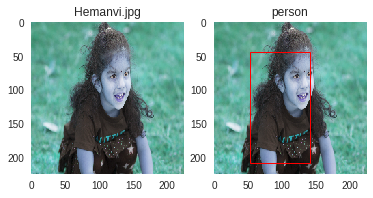

In [0]:
#ix = np.random.randint(1,100)
ix = 2
#filename = jpegs + single_object_images[ix]
test_predictions2(filename)

# Non max suppression

In [0]:
single_object_images[ix]

'2008_003013.jpg'

In [0]:
def extract_candidates2(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=100, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < (0.01*img_area):
            continue
        if r['size'] > (1*img_area):
            continue
        # distorted rects
        x, y, w, h = r['rect']
    #     if w / h > 1.2 or h / w > 1.2:
    #         continue
        candidates.append(list(r['rect']))
    return candidates

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


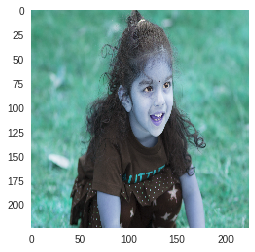

In [0]:
#filename = jpegs + single_object_images[ix]
img = cv2.imread(filename)
img = cv2.resize(img,(224,224))
img_area = img.shape[0]*img.shape[1]
candidates = extract_candidates(img)
plt.imshow(img)
plt.grid('off')

In [0]:
pred = []
pred_class = []
del_new = []

for ix, candidate in enumerate(candidates):

    l, t, w, h = np.array(candidate).astype(int)

    img2 = img[t:t+h,l:l+w,:3]
    img3 = cv2.resize(img2,(224,224))/255
    img4 = vgg16_model.predict(img3.reshape(1,224,224,3))  
    final_pred = model.predict(img4/x_train.max())
    delta_new = model2.predict(img4/x_train.max())[0]

    pred.append(np.max(final_pred))
    pred_class.append(np.argmax(final_pred))
    del_new.append(delta_new)

pred = np.array(pred)
pred_class = np.array(pred_class)

In [0]:
non_bgs = ((pred_class!=1))
pred = pred[non_bgs]
pred_class = pred_class[non_bgs]

del_new = np.array(del_new)
del_new = del_new[non_bgs]
del_pred = del_new*224

In [0]:
pred

array([0.81995696, 0.95336616, 0.9909349 , 0.9909349 , 0.9945701 ,
       0.99675614, 0.6267046 , 0.99675614, 0.99675614, 0.98460686,
       0.9214165 , 0.9267684 , 0.9721291 , 0.9267684 , 0.9267684 ,
       0.9267684 , 0.9267684 , 0.89126855], dtype=float32)

In [0]:
candidates = C = np.array(candidates)[non_bgs]
C = np.clip(C, 0, 224)
C[:,2] += C[:,0]
C[:,3] += C[:,1]

bbs_pred = candidates - del_pred
bbs_pred = np.clip(bbs_pred, 0, 224)

bbs_pred[:,2] -= bbs_pred[:,0]
bbs_pred[:,3] -= bbs_pred[:,1]

bbs_pred = np.clip(bbs_pred, 0, 224)

bbs_pred2 = bbs_pred[(bbs_pred[:,2]>0) & (bbs_pred[:,3]>0)]
pred = pred[(bbs_pred[:,2]>0) & (bbs_pred[:,3]>0)]
pred_class = pred_class[(bbs_pred[:,2]>0) & (bbs_pred[:,3]>0)]


In [0]:
bbs_pred2

array([[ 66.28803635,  25.33510971,  94.72128677, 190.79317093],
       [ 56.60316658,  45.80997467,  77.7767601 , 156.68434143],
       [ 54.90537786,  43.35234833,  80.54645014, 166.13275146],
       [ 54.90537786,  43.35234833,  80.54645014, 166.13275146],
       [ 55.6445446 ,  43.36237717,  83.83122635, 163.46256638],
       [ 52.36939621,  44.59030151,  88.6327877 , 163.17858124],
       [ 83.13263702,  28.45174408,  54.97383118, 114.20164776],
       [ 52.36939621,  44.59030151,  88.6327877 , 163.17858124],
       [ 52.36939621,  44.59030151,  88.6327877 , 163.17858124],
       [ 58.21765995,   7.59567928,  52.3189764 , 216.40432072],
       [ 45.84866667,  12.74362373,  86.05353594, 211.25637627],
       [ 47.49011612,  13.80656242,  82.42147255, 210.19343758],
       [ 52.8185482 ,  26.02074242,  56.12817955, 197.97925758],
       [ 47.49011612,  13.80656242,  82.42147255, 210.19343758],
       [ 47.49011612,  13.80656242,  82.42147255, 210.19343758],
       [ 47.49011612,  13

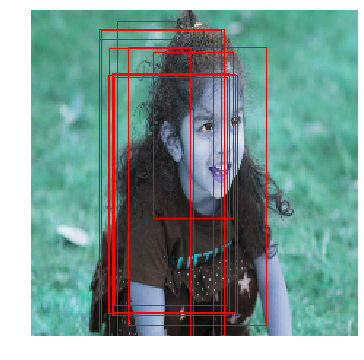

In [0]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)
for ix, (x, y, w, h) in enumerate(bbs_pred2):
    rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [0]:
print(len(pred), len(bbs_pred2))

18 18


In [0]:
def nms_boxes(threshold, boxes, scores):
  
        x = boxes[:, 0]
        y = boxes[:, 1]
        w = boxes[:, 2]
        h = boxes[:, 3]

        areas = w * h
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)

            xx1 = np.maximum(x[i], x[order[1:]])
            yy1 = np.maximum(y[i], y[order[1:]])
            xx2 = np.minimum(x[i] + w[i], x[order[1:]] + w[order[1:]])
            yy2 = np.minimum(y[i] + h[i], y[order[1:]] + h[order[1:]])

            w1 = np.maximum(0.0, xx2 - xx1 + 1)
            h1 = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w1 * h1

            ovr = inter / (areas[i] + areas[order[1:]] - inter)
            inds = np.where(ovr <= threshold)[0]
            order = order[inds + 1]

        keep = np.array(keep)

        return keep

In [0]:
keep_box_ixs = nms_boxes(0.3, bbs_pred2, pred)

In [0]:
pred

array([0.81995696, 0.95336616, 0.9909349 , 0.9909349 , 0.9945701 ,
       0.99675614, 0.6267046 , 0.99675614, 0.99675614, 0.98460686,
       0.9214165 , 0.9267684 , 0.9721291 , 0.9267684 , 0.9267684 ,
       0.9267684 , 0.9267684 , 0.89126855], dtype=float32)

In [0]:
keep_box_ixs

array([8])

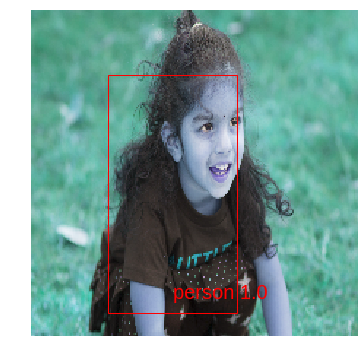

In [0]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)
for ix, (x, y, w, h) in enumerate(bbs_pred2):
    if ix not in keep_box_ixs:
        continue
    rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='red', linewidth=1,)
    ax.add_patch(rect)
    centerx = x + w/2
    centery = y + h - 10
    plt.text(centerx, centery,labels[pred_class[ix]]+" "+str(round(pred[ix],2)),fontsize = 20,color='red')

plt.axis('off')
plt.show()

In [0]:
labels

Index(['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
       'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tvmonitor'],
      dtype='object')